# Pipeline Leak Prediction — Baseline

Goals:
- Build a **single scikit-learn Pipeline** that featurizes text/cats/nums and trains a leak classifier.
- Use **stratified** splits (class imbalance).
- Tune the **decision threshold** on the **PR curve** (optimize F1).
- Save the whole pipeline (`.joblib`) for easy reuse.

Inputs:
- `work_orders_model_ready.csv` (from data_engineering notebook), OR use the in-memory `dataset/rep` if present.
Target:
- `target_leak` (1 = leak/burst, 0 = other)


In [1]:
# Import & data load
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, precision_recall_curve, RocCurveDisplay,
                             PrecisionRecallDisplay)
import joblib

df = pd.read_csv("outputs/work_orders_model_ready.csv")  # path created earlier
print("Rows:", len(df))
assert 'target_leak' in df.columns, "target_leak not found. Build model-ready table first."


Rows: 6260


## Select features
We'll combine:
- **Text**: `Problem_Description`, `Description`, `Location_Description` → concatenated into one text field
- **Categorical**: `Order Type`, `Priority`, `MaintActivType`, `System status`, `SYSTEM`, `SUB SYSTEM`, `feat_material`
- **Numeric**: `feat_age`, `feat_diameter`, plus optional cost fields if present

We keep IDs for later joins but **exclude** them from training.


In [2]:
# Feature selection & lightweight cleaning
# Text columns (use whichever exist)
text_cols = [c for c in ["Problem_Description","Description","Location_Description"] if c in df.columns]
df["text_all"] = df[text_cols].astype(str).agg(" \n ".join, axis=1) if text_cols else ""

# Categorical columns
cat_cols = [c for c in ["Order Type","Priority","MaintActivType","System status","SYSTEM","SUB SYSTEM","feat_material"] if c in df.columns]

# Numeric columns
num_cols = [c for c in ["feat_age","feat_diameter","Total act.costs","TotalPlnndCosts"] if c in df.columns]

# Target & ID columns
target_col = "target_leak"
id_cols = [c for c in ["Order","asset_key","pipe_key_match","PIPELINE NAME"] if c in df.columns]

# Keep training table
train_cols = ["text_all"] + cat_cols + num_cols + [target_col]
df_train = df[train_cols].copy()

# Basic NA handling for cats/nums (text handled by vectorizer)
for c in cat_cols:
    df_train[c] = df_train[c].astype("string").fillna("NA")
for c in num_cols:
    df_train[c] = pd.to_numeric(df_train[c], errors="coerce")

print("Shape:", df_train.shape)
print("Leak rate:", df_train[target_col].mean().round(4))


Shape: (6260, 10)
Leak rate: 0.1754


In [11]:
# Construct event_date (real if possible, else surrogate)

def _build_event_date_from_year_month(df, year_col="event_year", month_col="event_month", day=1):
    y = pd.to_numeric(df.get(year_col), errors="coerce")
    m = pd.to_numeric(df.get(month_col), errors="coerce")
    # only rows with both year and month → date; others become NaT
    mask = y.notna() & m.notna()
    out = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")
    out.loc[mask] = pd.to_datetime(
        dict(year=y[mask].astype(int), month=m[mask].astype(int), day=day),
        errors="coerce"
    )
    return out

if "event_date" not in df.columns:
    # Best case: we still have the original rep with true event_date; join it by Order
    if "rep" in globals() and "Order" in df.columns and "Order" in rep.columns and "event_date" in rep.columns:
        df = df.merge(rep[["Order","event_date"]], on="Order", how="left", suffixes=("", "_rep"))
        # prefer true event_date; if missing, fall back to surrogate
        if df["event_date"].isna().any():
            surrogate = _build_event_date_from_year_month(df, "event_year", "event_month", day=1)
            df["event_date"] = df["event_date"].fillna(surrogate)
    else:
        # No original available → make a surrogate from year/month (use day=1; change to 15 if you prefer mid-month)
        df["event_date"] = _build_event_date_from_year_month(df, "event_year", "event_month", day=1)

# diagnostics
print(
    "event_date present:",
    "event_date" in df.columns,
    "| non-null:",
    int(df["event_date"].notna().sum()),
    f"/ {len(df)}",
)
if df["event_date"].notna().any():
    print("event_date range:", df["event_date"].min(), "→", df["event_date"].max())


event_date present: True | non-null: 6260 / 6260
event_date range: 2017-08-01 00:00:00 → 2025-05-01 00:00:00


## Train/validation split (stratified)
We do a simple random stratified split. If you prefer **time-based** splits, swap this for a cutoff on `event_date`.


In [13]:
# Split
X = df_train.drop(columns=[target_col])
y = df_train[target_col].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "| Val:", X_val.shape, "| y mean (train/val):", y_train.mean().round(3), y_val.mean().round(3))


Train: (5008, 9) | Val: (1252, 9) | y mean (train/val): 0.175 0.176


## Build the sklearn Pipeline
- **TF-IDF** on `text_all` (char+word n-grams usually boost recall)
- **OneHot** for categoricals
- **Scaler** for numeric
- **LogisticRegression** with `class_weight="balanced"` as a strong baseline

Everything wrapped in a single `Pipeline` so it can be `fit`, `predict`, and `joblib.dump`’d as one object.


In [14]:
# Cell 4 — Preprocess + model pipeline

# Text features
text_feat = (
    "text",
    TfidfVectorizer(
        max_features=100_000,
        ngram_range=(1, 2),      # try (1, 3) for more recall later
        min_df=2,
        strip_accents="unicode",
        lowercase=True,
    ),
    "text_all",
)

# --- Build transformers list conditionally to avoid empty-column errors ---
transformers = [text_feat]

# Categorical (use sparse_output instead of sparse)
if len(cat_cols) > 0:
    cat_feat = (
        "cat",
        OneHotEncoder(handle_unknown="ignore", sparse_output=True),
        cat_cols,
    )
    transformers.append(cat_feat)

# Numeric (keep with_mean=False so it plays well if the final matrix is sparse)
if len(num_cols) > 0:
    num_feat = (
        "num",
        Pipeline(steps=[
            ("sc", StandardScaler(with_mean=False))
        ]),
        num_cols,
    )
    transformers.append(num_feat)

# ColumnTransformer will keep things sparse if enough subtransformers are sparse
preprocess = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    sparse_threshold=0.3,   # keep sparse when dominated by text/OHE
)

clf = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",        # robust on sparse matrices
    class_weight="balanced",
    max_iter=200,
    n_jobs=None if "n_jobs" not in LogisticRegression().get_params() else None  # safe across versions
)

pipe = Pipeline([
    ("prep", preprocess),
    ("clf",  clf),
])

pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=100000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  strip_accents='unicode'),
                                                  'text_all'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Order Type', 'Priority',
                                                   'MaintActivType',
                                                   'System status', 'SYSTEM',
                                                   'SUB SYSTEM']),
                                                 ('num',
                                                  Pipeline(steps=[('sc',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Total act.costs',
                                                   'TotalPlnndCosts'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=200,
                                    solver='liblinear'))])

## Fit & evaluate (threshold tuning via PR curve)
We optimize **F1** using the **precision–recall** curve, then report metrics.


ROC AUC: 0.995 | PR AUC: 0.977
Best F1=0.922 at threshold=0.556 (precision=0.907, recall=0.936)

Classification report (val @ tuned threshold):
              precision    recall  f1-score   support

           0      0.986     0.979     0.982      1032
           1      0.904     0.936     0.920       220

    accuracy                          0.971      1252
   macro avg      0.945     0.958     0.951      1252
weighted avg      0.972     0.971     0.971      1252

Confusion matrix (val):
[[1010   22]
 [  14  206]]


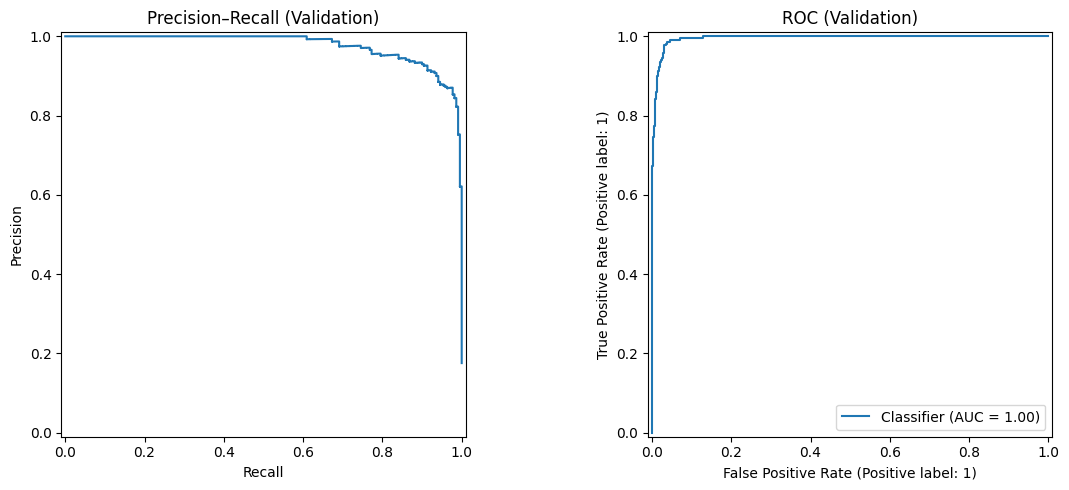

In [67]:
# Train
pipe.fit(X_train, y_train)

# Validation probabilities & default metrics
proba_val = pipe.predict_proba(X_val)[:, 1]
roc_val = roc_auc_score(y_val, proba_val)
pr_auc_val = average_precision_score(y_val, proba_val)
print(f"ROC AUC: {roc_val:.3f} | PR AUC: {pr_auc_val:.3f}")

# Tune threshold on PR curve to maximize F1
prec, rec, thr = precision_recall_curve(y_val, proba_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_ix = int(np.nanargmax(f1))
best_thr = thr[max(best_ix - 1, 0)] if best_ix < len(thr) else 0.5  # align lengths
print(f"Best F1={f1[best_ix]:.3f} at threshold={best_thr:.3f} (precision={prec[best_ix]:.3f}, recall={rec[best_ix]:.3f})")

# Predictions at tuned threshold
y_pred = (proba_val >= best_thr).astype(int)

print("\nClassification report (val @ tuned threshold):")
print(classification_report(y_val, y_pred, digits=3))

print("Confusion matrix (val):")
print(confusion_matrix(y_val, y_pred))

# Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
PrecisionRecallDisplay(precision=prec, recall=rec).plot(ax=ax[0])
ax[0].set_title("Precision–Recall (Validation)")

RocCurveDisplay.from_predictions(y_val, proba_val, ax=ax[1])
ax[1].set_title("ROC (Validation)")

plt.tight_layout()
plt.show()


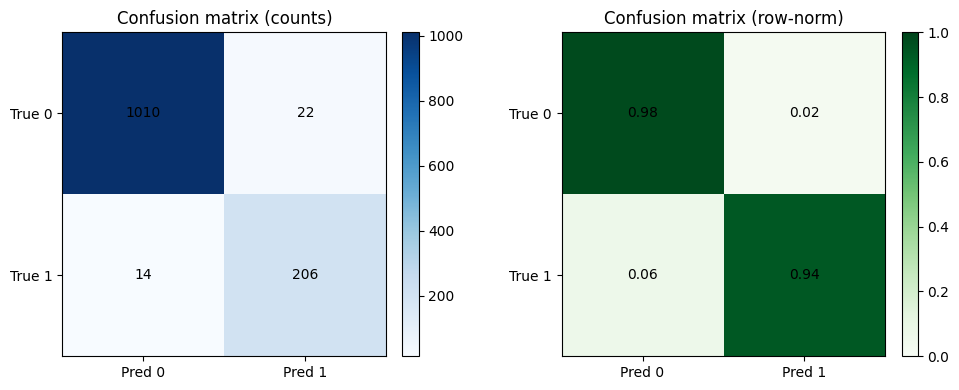

In [69]:
from sklearn.metrics import confusion_matrix

#y_pred = (y_score >= best_thr).astype(int)
cm = confusion_matrix(y_val, y_pred, labels=[0,1])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

# raw counts
im0 = ax[0].imshow(cm, cmap="Blues")
ax[0].set_title("Confusion matrix (counts)")
ax[0].set_xticks([0,1]); ax[0].set_yticks([0,1])
ax[0].set_xticklabels(["Pred 0","Pred 1"]); ax[0].set_yticklabels(["True 0","True 1"])
for i in range(2):
    for j in range(2):
        ax[0].text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# normalized
im1 = ax[1].imshow(cm_norm, vmin=0, vmax=1, cmap="Greens")
ax[1].set_title("Confusion matrix (row-norm)")
ax[1].set_xticks([0,1]); ax[1].set_yticks([0,1])
ax[1].set_xticklabels(["Pred 0","Pred 1"]); ax[1].set_yticklabels(["True 0","True 1"])
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", color="black")
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("fig_confusion_matrix.png", dpi=200)
plt.show()


Brier score (val): 0.0291


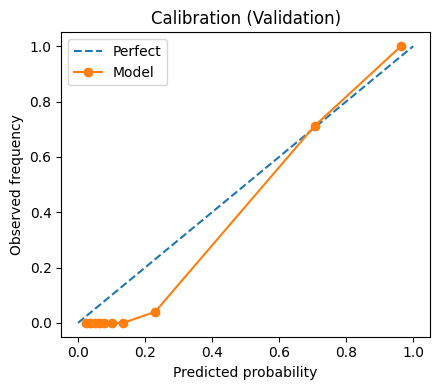

In [68]:
# Quick calibration check (Brier & reliability curve)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob = proba_val
bs = brier_score_loss(y_val, prob)
print(f"Brier score (val): {bs:.4f}")

frac_pos, mean_pred = calibration_curve(y_val, prob, n_bins=10, strategy="quantile")
plt.figure(figsize=(4.5,4))
plt.plot([0,1],[0,1],'--', label='Perfect')
plt.plot(mean_pred, frac_pos, marker='o', label='Model')
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Calibration (Validation)')
plt.legend(); plt.tight_layout(); plt.show()


In [17]:
# Time-based split (sanity): train on older, validate on newer
if "event_date" in df.columns and pd.api.types.is_datetime64_any_dtype(df["event_date"]):
    cutoff = df["event_date"].quantile(0.8)  # 80% oldest → train
    df_t = df_train.copy()
    df_t["event_date"] = df["event_date"]
    tr = df_t["event_date"] <= cutoff
    va = df_t["event_date"] >  cutoff

    X_tr, y_tr = df_t.loc[tr].drop(columns=[target_col, "event_date"]), df_t.loc[tr, target_col].astype(int)
    X_va, y_va = df_t.loc[va].drop(columns=[target_col, "event_date"]), df_t.loc[va, target_col].astype(int)

    print("Time split sizes:", X_tr.shape, X_va.shape)
    pipe.fit(X_tr, y_tr)
    p = pipe.predict_proba(X_va)[:,1]
    print(f"Time-split ROC AUC: {roc_auc_score(y_va, p):.3f} | PR AUC: {average_precision_score(y_va, p):.3f}")


Time split sizes: (5041, 9) (1219, 9)
Time-split ROC AUC: 0.997 | PR AUC: 0.987


## Top text signals (positive vs negative)
For interpretability: show top weighted n-grams from the TF-IDF + Logistic Regression combo.


In [19]:
# Inspect top coefficients (text only)
# Note: We need to get the feature names after fitting
prep = pipe.named_steps["prep"]
clf = pipe.named_steps["clf"]

# get feature name ranges for each transformer
names_text = prep.named_transformers_["text"].get_feature_names_out()
n_text = len(names_text)

# ColumnTransformer stacks features as [text | cat | num] in order added.
coef = clf.coef_.ravel()

text_coef = coef[:n_text]
top_pos_idx = np.argsort(text_coef)[-20:][::-1]
top_neg_idx = np.argsort(text_coef)[:20]

print("Top positive text features (more 'leak'):")
for i in top_pos_idx:
    print(f"{names_text[i]:<30s}  {text_coef[i]: .3f}")

print("\nTop negative text features (less 'leak'):")
for i in top_neg_idx:
    print(f"{names_text[i]:<30s}  {text_coef[i]: .3f}")


Top positive text features (more 'leak'):
leak                             15.006
leaking                          12.608
burst                            7.056
pipe                             4.843
leak at                          4.654
burst pipe                       4.043
leak on                          3.602
check leak                       3.184
repair leak                      2.906
repair                           2.722
pipe at                          2.568
check                            2.510
to leak                          2.368
attend                           2.234
water leak                       2.009
pipe leak                        1.981
repair burst                     1.955
repair leaking                   1.950
attend to                        1.803
to leaking                       1.718

Top negative text features (less 'leak'):
install                         -2.009
grass                           -1.828
no water                        -1.719
cut             

## Save the trained pipeline
This dumps the **entire** preprocessing + model pipeline. Load it later with `joblib.load`.


In [20]:
# Cell 7 — Save model
joblib.dump({
    "pipeline": pipe,
    "threshold": float(best_thr),
    "feature_config": {
        "text_cols": text_cols,
        "cat_cols": cat_cols,
        "num_cols": num_cols,
        "target_col": target_col
    }
}, "models/leak_model_logreg.joblib")

print("Saved: leak_model_logreg.joblib")


Saved: leak_model_logreg.joblib


## Inference helper (use in production/testing)
Given a DataFrame with the same columns, this helper returns probabilities and labels using the saved threshold.


In [24]:
# Inference function
def predict_leaks(df_in: pd.DataFrame, model_path: str = "models/leak_model_logreg.joblib") -> pd.DataFrame:
    bundle = joblib.load(model_path)
    pipe = bundle["pipeline"]
    thr = bundle["threshold"]
    cfg = bundle["feature_config"]

    # build text_all exactly as during training
    df = df_in.copy()
    if cfg["text_cols"]:
        df["text_all"] = df[cfg["text_cols"]].astype(str).agg(" \n ".join, axis=1)
    else:
        df["text_all"] = ""

    # ensure missing columns exist (cats/nums)
    for c in cfg["cat_cols"]:
        if c not in df.columns:
            df[c] = "NA"
        df[c] = df[c].astype("string").fillna("NA")
    for c in cfg["num_cols"]:
        if c not in df.columns:
            df[c] = np.nan
        df[c] = pd.to_numeric(df[c], errors="coerce")

    X = df[["text_all"] + cfg["cat_cols"] + cfg["num_cols"]]
    proba = pipe.predict_proba(X)[:, 1]
    pred  = (proba >= thr).astype(int)
    return pd.DataFrame({"proba_leak": proba, "pred_leak": pred}, index=df.index)

In [25]:
preds = predict_leaks(df.sample(5, random_state=0))
preds.head()

,proba_leak,pred_leak
3449,0.711100,1
4130,0.038834,0
5138,0.045976,0
842,0.131460,0
4261,0.309337,0


---

# Deep Learning Baselines (Keras)

We build three DL baselines:
1. **Text-only** BiLSTM over tokenized `text_all`.
2. **Tabular-only** MLP with learned embeddings for categoricals.
3. **Fusion** (text ⨉ tabular) with concatenation.

All use EarlyStopping and threshold tuning on the validation set.


In [28]:
# Imports & data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except Exception as e:
    raise RuntimeError("TensorFlow/Keras not available. Please install tensorflow first.") from e

df_two = pd.read_csv("outputs/work_orders_model_ready.csv")

df_two["event_date"] = _build_event_date_from_year_month(df_two, "event_year", "event_month", day=1)

assert 'target_leak' in df_two.columns, "target_leak missing."
# Text column (concatenate earlier if needed)
if 'text_all' not in df_two.columns:
    text_cols = [c for c in ["Problem_Description","Description","Location_Description"] if c in df.columns]
    df_two["text_all"] = df_two[text_cols].astype(str).agg(" \n ".join, axis=1) if text_cols else ""


## Train/validation split (stratified)
We’ll reuse the feature selection from before:
- **Categorical**: `Order Type`, `Priority`, `MaintActivType`, `System status`, `SYSTEM`, `SUB SYSTEM`, `feat_material`
- **Numeric**: `feat_age`, `feat_diameter`, `Total act.costs`, `TotalPlnndCosts`


In [29]:
# Cell DL-1 — Feature lists and split
cat_cols = [c for c in ["Order Type","Priority","MaintActivType","System status","SYSTEM","SUB SYSTEM","feat_material"] if c in df_two.columns]
num_cols = [c for c in ["feat_age","feat_diameter","Total act.costs","TotalPlnndCosts"] if c in df_two.columns]

# minimal cleaning
X_text = df_two["text_all"].astype(str)
X_cat = df_two[cat_cols].astype("string").fillna("NA") if cat_cols else pd.DataFrame(index=df_two.index)
X_num = df_two[num_cols].apply(pd.to_numeric, errors="coerce") if num_cols else pd.DataFrame(index=df_two.index)
y = df_two["target_leak"].astype(int).values

# split
X_train_text, X_val_text, \
X_train_cat,  X_val_cat,  \
X_train_num,  X_val_num,  \
y_train, y_val = train_test_split(
    X_text, X_cat, X_num, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(y_train), "| Val size:", len(y_val), "| Leak rate train/val:", y_train.mean().round(3), y_val.mean().round(3))


Train size: 5008 | Val size: 1252 | Leak rate train/val: 0.175 0.176


## Text-only model (BiLSTM)
Pipeline:
`text_all → TextVectorization → Embedding → BiLSTM(64) → Dense(64, ReLU, dropout) → Dense(1, sigmoid)`


In [32]:
# Text-only model
# Text vectorizer (learned vocab)
VOCAB_SIZE   = 30000
SEQ_LENGTH   = 200

text_vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
)
text_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train_text).batch(256))

# Build model
inputs_txt = keras.Input(shape=(), dtype=tf.string, name="text")
x = text_vectorizer(inputs_txt)
x = layers.Embedding(VOCAB_SIZE, 128, name="emb")(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation="sigmoid")(x)

model_text = keras.Model(inputs=inputs_txt, outputs=out, name="text_only_bilstm")
model_text.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["AUC", keras.metrics.AUC(curve="PR", name="AUC_PR")])
model_text.summary()


Model: "text_only_bilstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text (InputLayer)               │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ emb (Embedding)                 │ (None, 200, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,947,137 (15.06 MB)

 Trainable params: 3,947,137 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train text-only with class weights + callbacks
# class weights
pos = y_train.sum()
neg = len(y_train) - pos
class_weight = {
    0: float(len(y_train) / (2.0 * max(neg, 1))),
    1: float(len(y_train) / (2.0 * max(pos, 1)))
}
print("Class weight:", class_weight)

cb = [
    keras.callbacks.EarlyStopping(
        monitor="val_AUC_PR", 
        mode="max", 
        patience=3, 
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        "dl_text_only_best.keras", 
        monitor="val_AUC_PR", 
        mode="max", 
        save_best_only=True
    )
]

# Cast inputs to proper NumPy dtypes
x_tr = X_train_text.astype(str).to_numpy()
y_tr = y_train.astype("float32")

x_va = X_val_text.astype(str).to_numpy()
y_va = y_val.astype("float32")

history = model_text.fit(
    x=x_tr, y=y_tr,
    validation_data=(x_va, y_va),
    epochs=15, batch_size=256,
    class_weight=class_weight,
    callbacks=cb, verbose=1
)

# Evaluate + threshold tuning
proba = model_text.predict(x_va, batch_size=512).ravel()
roc  = roc_auc_score(y_val, proba)
pra  = average_precision_score(y_val, proba)
prec, rec, thr = precision_recall_curve(y_val, proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_ix = int(np.nanargmax(f1))
best_thr_text = thr[max(best_ix - 1, 0)] if best_ix < len(thr) else 0.5

print(f"[Text-only] ROC AUC={roc:.3f} | PR AUC={pra:.3f} | Best F1={f1[best_ix]:.3f} @ thr={best_thr_text:.3f}")
print(classification_report(y_val, (proba >= best_thr_text).astype(int), digits=3))
print(confusion_matrix(y_val, (proba >= best_thr_text).astype(int)))


Class weight: {0: 0.6062953995157385, 1: 2.8519362186788153}
Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 705ms/step - AUC: 1.0000 - AUC_PR: 1.0000 - loss: 0.0013 - val_AUC: 0.9950 - val_AUC_PR: 0.9929 - val_loss: 0.0258
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - AUC: 1.0000 - AUC_PR: 1.0000 - loss: 5.5209e-04 - val_AUC: 0.9929 - val_AUC_PR: 0.9906 - val_loss: 0.0305
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - AUC: 1.0000 - AUC_PR: 1.0000 - loss: 6.8011e-04 - val_AUC: 0.9924 - val_AUC_PR: 0.9861 - val_loss: 0.0291
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - AUC: 1.0000 - AUC_PR: 1.0000 - loss: 3.3255e-04 - val_AUC: 0.9924 - val_AUC_PR: 0.9861 - val_loss: 0.0317
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 967ms/step
[Text-only] ROC AUC=0.999 | PR AUC=0.997 | Best F1=0.982 @ thr=0.318
              precision    recall  f1-score   support

           0      0.996     0.995     0.996      1032
           1      0.977     0.982     0.980       220

    accuracy                        

## Tabular-only model (MLP with categorical embeddings)
- For each categorical feature, we learn a small embedding.
- Numeric features are standardized with a `Normalization` layer.


In [38]:
# Build tabular dataset tensors
# Handle empty cases
if len(cat_cols) == 0 and len(num_cols) == 0:
    print("No tabular features available. Skip tabular-only model.")
else:
    import re
    # Freeze unique categories (fit on train)

    def safe_name(s: str) -> str:
        # Lowercase, replace spaces with underscores, drop invalid chars
        s2 = re.sub(r"[^\w.\-]", "_", s.strip().lower())
        return s2 or "field"
    
    # Build unique safe names (handle collisions)
    cat_safe = {}
    used = set()
    for c in cat_cols:
        base = safe_name(c)
        name = base
        i = 1
        while name in used:
            name = f"{base}_{i}"
            i += 1
        used.add(name)
        cat_safe[c] = name # mapping: original col → safe unique name
    
    # Freeze unique categories (fit on train)
    cat_vocabs = {}
    for c in cat_cols:
        vocab = sorted(pd.Series(X_train_cat[c].astype(str)).unique().tolist())
        # reserve 0 for unknown
        cat_vocabs[c] = {v: i for i, v in enumerate(vocab)}
        
    # numeric normalizer
    if len(num_cols) > 0:
        norm_layer = layers.Normalization()
        norm_layer.adapt(np.nan_to_num(X_train_num.values.astype("float32")))


In [40]:
# Tabular-only model definition & training
if len(cat_cols) == 0 and len(num_cols) == 0:
    model_tab = None
else:
    inputs_list = []
    embeds_list = []

    # categorical branches with embeddings
    for c in cat_cols:
        sname = cat_safe[c]
        inp = keras.Input(shape=(1,), dtype="int32", name=f"cat_{sname}")
        vocab_size = len(cat_vocabs[c]) + 1 # +1 for unknown (index 0)
        dim = min(50, max(4, int(np.ceil(np.log2(vocab_size)))))  # small, sensible embedding size
        emb = layers.Embedding(vocab_size, dim, name=f"emb_{sname}")(inp)
        emb = layers.Reshape((dim,))(emb)
        inputs_list.append(inp)
        embeds_list.append(emb)

    # numeric branch
    if len(num_cols) > 0:
        inp_num = keras.Input(shape=(len(num_cols),), dtype="float32", name="num")
        num_norm = norm_layer(inp_num)
        inputs_list.append(inp_num)
        embeds_list.append(num_norm)

    x = layers.Concatenate()(embeds_list) if len(embeds_list) > 1 else embeds_list[0]
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model_tab = keras.Model(inputs=inputs_list, outputs=out, name="tabular_mlp")
    model_tab.compile(
        optimizer=keras.optimizers.Adam(1e-3), 
        loss="binary_crossentropy", 
        metrics=["AUC", keras.metrics.AUC(curve="PR", name="AUC_PR")]
    )
    model_tab.summary()

    # Build numpy inputs matching with safe keys
    def encode_cats(df_cat: pd.DataFrame) -> dict:
        encoded = {}
        for c in cat_cols:
            idx = df_cat[c].astype(str).map(cat_vocabs[c]).fillna(0).astype("int32").values
            encoded[f"cat_{cat_safe[c]}"] = idx
        return encoded

    Xtr_dict = encode_cats(X_train_cat)
    Xva_dict = encode_cats(X_val_cat)
    if len(num_cols) > 0:
        Xtr_dict["num"] = np.nan_to_num(X_train_num.values.astype("float32"))
        Xva_dict["num"] = np.nan_to_num(X_val_num.values.astype("float32"))

    cb2 = [
        keras.callbacks.EarlyStopping(
            monitor="val_AUC_PR", mode="max", 
            patience=3, restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            "dl_tabular_best.keras", 
            monitor="val_AUC_PR", 
            mode="max", save_best_only=True
        )
    ]
    history_tab = model_tab.fit(
        Xtr_dict, y_train,
        validation_data=(Xva_dict, y_val),
        epochs=20, batch_size=512,
        class_weight=class_weight,
        callbacks=cb2, verbose=1
    )

    proba_tab = model_tab.predict(Xva_dict, batch_size=1024).ravel()
    roc_tab  = roc_auc_score(y_val, proba_tab)
    pra_tab  = average_precision_score(y_val, proba_tab)
    p2, r2, t2 = precision_recall_curve(y_val, proba_tab)
    f12 = 2 * (p2 * r2) / (p2 + r2 + 1e-12)
    best_ix2 = int(np.nanargmax(f12))
    best_thr_tab = t2[max(best_ix2 - 1, 0)] if best_ix2 < len(t2) else 0.5

    print(f"[Tabular] ROC AUC={roc_tab:.3f} | PR AUC={pra_tab:.3f} | Best F1={f12[best_ix2]:.3f} @ thr={best_thr_tab:.3f}")
    print(classification_report(y_val, (proba_tab >= best_thr_tab).astype(int), digits=3))
    print(confusion_matrix(y_val, (proba_tab >= best_thr_tab).astype(int)))


Model: "tabular_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat_order_type      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_priority        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_maintactivtype  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_system_status   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_system          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_sub_system      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_order_type      │ (None, 1, 4)      │         16 │ cat_order_type[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_priority        │ (None, 1, 4)      │         28 │ cat_priority[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_maintactivtype  │ (None, 1, 4)      │         48 │ cat_maintactivty… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_system_status   │ (None, 1, 7)      │        504 │ cat_system_statu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_system          │ (None, 1, 4)      │         20 │ cat_system[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_sub_system      │ (None, 1, 4)      │         20 │ cat_sub_system[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num (InputLayer)    │ (None, 2)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 4)         │          0 │ emb_order_type[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 4)         │          0 │ emb_priority[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 4)         │          0 │ emb_maintactivty… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 7)         │          0 │ emb_system_statu… │
│ (Reshape)           │                   │            │                 

 Total params: 12,802 (50.01 KB)

 Trainable params: 12,797 (49.99 KB)

 Non-trainable params: 5 (24.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - AUC: 0.5779 - AUC_PR: 0.2369 - loss: 0.6985 - val_AUC: 0.7249 - val_AUC_PR: 0.4520 - val_loss: 0.6463
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.7031 - AUC_PR: 0.4103 - loss: 0.6738 - val_AUC: 0.7642 - val_AUC_PR: 0.5139 - val_loss: 0.6127
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7999 - AUC_PR: 0.5921 - loss: 0.6285 - val_AUC: 0.7813 - val_AUC_PR: 0.5927 - val_loss: 0.5405
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.7980 - AUC_PR: 0.6133 - loss: 0.5656 - val_AUC: 0.7896 - val_AUC_PR: 0.5994 - val_loss: 0.4684
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.8191 - AUC_PR: 0.6410 - loss: 0.5034 - val_AUC: 0.7973 - val_AUC_PR: 0.6234 - val_loss: 0.4373
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.8253 - AUC_PR: 0.6658 - loss: 0.4708 - val_AUC: 0.8029 - val_AUC_PR: 0.6238 - val_loss: 0.4454
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.8431 - AUC

## Fusion model
We merge the BiLSTM text branch with the tabular MLP branch.


In [43]:
# Fusion model

#Ensure prerequisites exist (cat_cols/num_cols, cat_vocabs, norm_layer, cat_safe)
if 'cat_cols' not in globals():
    cat_cols = [
        c for c in [
            "Order Type","Priority","MaintActivType",
            "System status","SYSTEM","SUB SYSTEM",
            "feat_material"
        ] if c in df_two.columns
]
if 'num_cols' not in globals():
    num_cols = [
        c for c in [
            "feat_age","feat_diameter",
            "Total act.costs","TotalPlnndCosts"
        ] if c in df_two.columns
]

if 'cat_safe' not in globals():
    cat_safe, used = {}, set()
    for c in cat_cols:
        base, name, k = safe_name(c), None, 1
        name = base
        while name in used:
            k += 1; name = f"{base}_{k}"
        used.add(name)
        cat_safe[c] = name

# Build/ensure cat_vocabs (reserve 0 for unknown) and norm_layer
if 'cat_vocabs' not in globals():
    cat_vocabs = {}
    for c in cat_cols:
        vocab = sorted(pd.Series(X_train_cat[c].astype(str)).unique().tolist())
        cat_vocabs[c] = {v: i + 1 for i, v in enumerate(vocab)}  # start from 1

if len(num_cols) > 0 and 'norm_layer' not in globals():
    norm_layer = layers.Normalization()
    norm_layer.adapt(np.nan_to_num(X_train_num.values.astype("float32")))

# Text branch (reuse the same vectorizer to be consistent)
if 'text_vectorizer' not in globals():
    text_vectorizer = layers.TextVectorization(
        max_tokens=VOCAB_SIZE,
        output_mode="int",
        output_sequence_length=SEQ_LENGTH,
        standardize="lower_and_strip_punctuation",
        split="whitespace",
    )
    text_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train_text).batch(256))
else:
    # infer VOCAB_SIZE from existing vectorizer
    VOCAB_SIZE = getattr(text_vectorizer, 'max_tokens', None) or VOCAB_SIZE
    SEQ_LENGTH = getattr(text_vectorizer, 'output_sequence_length', None) or SEQ_LENGTH

inputs_txt = keras.Input(shape=(), dtype=tf.string, name="text")
tx = text_vectorizer(inputs_txt)
tx = layers.Embedding(VOCAB_SIZE, 128, name="emb_text")(tx)
tx = layers.Bidirectional(layers.LSTM(64))(tx)
tx = layers.Dropout(0.3)(tx)

# Tabular branch (reuse cat vocabs & numeric normalizer if available)
inputs_fusion = {"text": inputs_txt}
branches = [tx]

tab_iputs = []
tab_feats = []


for c in cat_cols:
    sname = cat_safe[c] #sanitized unique name
    inp = keras.Input(shape=(1,), dtype="int32", name=f"cat_{sname}")
    vocab_size = len(cat_vocabs[c]) + 1
    dim = min(50, max(4, int(np.ceil(np.log2(vocab_size)))))
    emb = layers.Embedding(vocab_size, dim, name=f"emb_{sname}")(inp)
    emb = layers.Reshape((dim,))(emb)
    tab_iputs.append(inp); tab_feats.append(emb)
    inputs_fusion[f"cat_{sname}"] = inp

if len(num_cols) > 0:
    inp_num = keras.Input(shape=(len(num_cols),), dtype="float32", name="num")
    num_norm = norm_layer(inp_num)
    tab_iputs.append(inp_num); tab_feats.append(num_norm)
    inputs_fusion["num"] = inp_num

if len(tab_feats):
    tab = layers.Concatenate()(tab_feats) if len(tab_feats) > 1 else tab_feats[0]
    tab = layers.Dense(128, activation="relu")(tab)
    tab = layers.Dropout(0.3)(tab)
    branches.append(tab)

z = layers.Concatenate()(branches) if len(branches) > 1 else branches[0]
z = layers.Dense(128, activation="relu")(z)
z = layers.Dropout(0.2)(z)
out = layers.Dense(1, activation="sigmoid")(z)

model_fuse = keras.Model(
    inputs=list(inputs_fusion.values()), 
    outputs=out, 
    name="fusion_text_tabular"
)
model_fuse.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss="binary_crossentropy", 
    metrics=[
        "AUC", 
        keras.metrics.AUC(curve="PR", name="AUC_PR")
    ]
)
model_fuse.summary()

Model: "fusion_text_tabular"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat_order_type      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_priority        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_maintactivtype  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_system_status   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_system          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_sub_system      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_order_type      │ (None, 1, 4)      │         16 │ cat_order_type[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_priority        │ (None, 1, 4)      │         28 │ cat_priority[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_maintactivtype  │ (None, 1, 4)      │         48 │ cat_maintactivty… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_system_status   │ (None, 1, 7)      │        504 │ cat_system_statu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_system          │ (None, 1, 4)      │         20 │ cat_system[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_sub_system      │ (None, 1, 4)      │         20 │ cat_sub_system[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num (InputLayer)    │ (None, 2)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 200)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_24          │ (None, 4)         │          0 │ emb_order_type[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_25          │ (None, 4)         │          0 │ emb_priority[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,976,322 (15.17 MB)

 Trainable params: 3,976,317 (15.17 MB)

 Non-trainable params: 5 (24.00 B)

In [44]:
# Train fusion with matching feed dict keys
def encode_cats_with_safe(df_cat: pd.DataFrame) -> dict:
    enc = {}
    for c in cat_cols:
        idx = df_cat[c].astype(str).map(cat_vocabs[c]).fillna(0).astype("int32").values
        enc[f"cat_{cat_safe[c]}"] = idx
    return enc

feed_train = {"text": X_train_text.astype(str).to_numpy()}
feed_val   = {"text": X_val_text.astype(str).to_numpy()}

if len(cat_cols) > 0:
    feed_train.update(encode_cats_with_safe(X_train_cat))
    feed_val.update(encode_cats_with_safe(X_val_cat))

if len(num_cols) > 0:
    feed_train["num"] = np.nan_to_num(X_train_num.values.astype("float32"))
    feed_val["num"]   = np.nan_to_num(X_val_num.values.astype("float32"))

# Safety: drop any keys not in model inputs (prevents accidental mismatches)
model_input_names = {l.name for l in model_fuse.inputs}
feed_train = {k: v for k, v in feed_train.items() if k in model_input_names}
feed_val   = {k: v for k, v in feed_val.items()   if k in model_input_names}

cb3 = [
    keras.callbacks.EarlyStopping(monitor="val_AUC_PR", mode="max", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("dl_fusion_best.keras", monitor="val_AUC_PR", mode="max", save_best_only=True)
]

hist_fuse = model_fuse.fit(
    feed_train, y_train,
    validation_data=(feed_val, y_val),
    epochs=15, batch_size=256,
    class_weight=class_weight,
    callbacks=cb3, verbose=1
)

proba_f = model_fuse.predict(feed_val, batch_size=512).ravel()
roc_f  = roc_auc_score(y_val, proba_f)
pra_f  = average_precision_score(y_val, proba_f)
prec_f, rec_f, thr_f = precision_recall_curve(y_val, proba_f)
f1_f = 2 * (prec_f * rec_f) / (prec_f + rec_f + 1e-12)
best_ixf = int(np.nanargmax(f1_f))
best_thr_fuse = thr_f[max(best_ixf - 1, 0)] if best_ixf < len(thr_f) else 0.5

print(f"[Fusion] ROC AUC={roc_f:.3f} | PR AUC={pra_f:.3f} | Best F1={f1_f[best_ixf]:.3f} @ thr={best_thr_fuse:.3f}")
print(classification_report(y_val, (proba_f >= best_thr_fuse).astype(int), digits=3))
print(confusion_matrix(y_val, (proba_f >= best_thr_fuse).astype(int)))


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 419ms/step - AUC: 0.7407 - AUC_PR: 0.3880 - loss: 0.6482 - val_AUC: 0.9348 - val_AUC_PR: 0.7770 - val_loss: 0.4363
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 515ms/step - AUC: 0.9669 - AUC_PR: 0.8835 - loss: 0.2749 - val_AUC: 0.9875 - val_AUC_PR: 0.9655 - val_loss: 0.1039
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - AUC: 0.9975 - AUC_PR: 0.9914 - loss: 0.0639 - val_AUC: 0.9974 - val_AUC_PR: 0.9898 - val_loss: 0.0579
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - AUC: 0.9990 - AUC_PR: 0.9973 - loss: 0.0311 - val_AUC: 0.9965 - val_AUC_PR: 0.9926 - val_loss: 0.0341
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 537ms/step - AUC: 0.9999 - AUC_PR: 0.9997 - loss: 0.0125 - val_AUC: 0.9988 - val_AUC_PR: 0.9954 - val_loss: 0.0308
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step - AUC: 0.9999 - AUC_PR: 0.9998 - loss: 0.0073 - val_AUC: 0.9989 - val_AUC_PR: 0.9959 - val_loss: 0.0302
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 501ms/step - AUC

## Save & inference (DL)
We save the **best fusion model** and provide a small inference wrapper that prepares inputs the same way.


In [49]:
# Save fusion
model_fuse.save("models/leak_fusion_best.keras")
print("Saved: leak_fusion_best.keras (includes TextVectorization & Normalization)")

# Inference helper
def predict_leaks_dl(df_in: pd.DataFrame, model_path: str = "models/leak_fusion_best.keras",
                     cat_columns=None, num_columns=None, cat_vocab_maps=None, text_col="text_all"):
    mdl = keras.models.load_model(model_path)

    # Create unique sanitized names (handle collisions deterministically)
    cat_columns = cat_columns or []
    used = set()
    cat_safe = {}
    for c in cat_columns:
        base = safe_name(c)
        name, k = base, 1
        while name in used:
            k += 1
            name = f"{base}_{k}"
        used.add(name)
        cat_safe[c] = name

    din = df_in.copy()

    # text
    if text_col not in din.columns:
        text_cols = [c for c in ["Problem_Description","Description","Location_Description"] if c in din.columns]
        din[text_col] = din[text_cols].astype(str).agg(" \n ".join, axis=1) if text_cols else ""

    feed = {"text": din[text_col].astype(str).to_numpy()}

    # cats
    if cat_columns and cat_vocab_maps:
        for c in cat_columns:
            vals = din.get(c, pd.Series("NA", index=din.index)).astype("string").fillna("NA")
            idx = vals.map(cat_vocab_maps[c]).fillna(0).astype("int32").to_numpy()
            feed[f"cat_{cat_safe[c]}"] = idx

    # nums
    if num_columns:
        arr = din[num_columns].apply(pd.to_numeric, errors="coerce").values.astype("float32")
        arr = np.nan_to_num(arr)
        feed["num"] = arr

    proba = mdl.predict(feed, batch_size=1024).ravel()
    return proba


Saved: leak_fusion_best.keras (includes TextVectorization & Normalization)


In [51]:
p = predict_leaks_dl(
    df.sample(5, random_state=0),
    model_path="models/leak_fusion_best.keras",
    cat_columns=cat_cols,
    num_columns=num_cols,
    cat_vocab_maps=cat_vocabs,
)
p


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


array([9.9993771e-01, 1.6185220e-05, 9.3082381e-06, 5.7443808e-04,
       4.8191126e-02], dtype=float32)

In [52]:
thr = best_thr_fuse  # e.g., 0.556 from your PR tuning
pred = (p >= thr).astype(int)
pred


array([1, 0, 0, 0, 0])

In [53]:
sample = df_two.sample(5, random_state=0).copy()
sample["proba_leak"] = p
sample["pred_leak"]  = (p >= thr).astype(int)

cols_show = [c for c in ["Order","PIPELINE NAME","pipe_key_match","Problem_Description",
                         "MaintActivType","SYSTEM","SUB SYSTEM","feat_material",
                         "feat_age","feat_diameter"] if c in sample.columns]
sample[cols_show + ["proba_leak","pred_leak"]].sort_values("proba_leak", ascending=False)


,Order,PIPELINE NAME,pipe_key_match,Problem_Description,MaintActivType,SYSTEM,SUB SYSTEM,proba_leak,pred_leak
3449,760163,NaN,NaN,Pls repair pipe leak S/Grove Guard House,CMN,NaN,NaN,0.999938,1
4261,763588,Howick West Pipeline,howick west pipeline,Check Point M pressure pipe,CMN,Upper Mgeni,Midmar,0.048191,0
842,789269,Eston-Umbumbulu Pipeline,eston umbumbulu pipeline,Repair chamber lid at Umbumbulu-Craig,CMN,Upper Mgeni,Midmar,0.000574,0
4130,90013363,’56 Pipeline,56 pipeline,Open Blackridge Res inlet.,CMC,Upper Mgeni,Midmar,0.000016,0
5138,765148,NaN,NaN,Cur the grass at Umlaas Road,CMN,NaN,NaN,0.000009,0


In [54]:
# For validation set
proba_val_fuse = model_fuse.predict(feed_val, batch_size=512).ravel()
pred_val_fuse  = (proba_val_fuse >= thr).astype(int)

val_out = df.loc[X_val_text.index, ["Order"]].copy() if "Order" in df.columns else pd.DataFrame(index=X_val_text.index)
val_out["proba_leak"] = proba_val_fuse
val_out["pred_leak"]  = pred_val_fuse
val_out.to_csv("outputs/val_predictions_fusion.csv", index=False)
print("Saved: val_predictions_fusion.csv")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Saved: val_predictions_fusion.csv


In [55]:
top_risk = df.copy()
top_risk["proba_leak"] = model_fuse.predict(
    {"text": df["text_all"].astype(str).to_numpy(),
     **({f"cat_{cat_safe[c]}": df[c].astype(str).map(cat_vocabs[c]).fillna(0).astype("int32").to_numpy() for c in cat_cols} if len(cat_cols) else {}),
     **({"num": np.nan_to_num(df[num_cols].apply(pd.to_numeric, errors="coerce").values.astype("float32"))} if len(num_cols) else {})},
    batch_size=1024
).ravel()
cols = [c for c in ["Order","PIPELINE NAME","Problem_Description","feat_material","feat_age","feat_diameter"] if c in df.columns]
top_risk[cols + ["proba_leak"]].sort_values("proba_leak", ascending=False).head(20)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step


,Order,PIPELINE NAME,Problem_Description,proba_leak
4,778880,’53 Pipeline,attend pipe leak at 53p/l,0.999997
11,90015047,’61 Pipeline,Attend to the burst pipe at Umlaas Rd c/,0.999990
140,779197,’56 Pipeline,Attend to a leak; Mpophomeni line,0.999987
337,744068,Wartburg Pipeline(’69 Pipeline),repair burst pipe at wartburg pipe line,0.999986
2186,90008264,NaN,Fix water pipe leak next to staff quator,0.999983
663,755331,NaN,Repair domesti pipe leak,0.999982
100,90015045,Howick West Pipeline,Pipe leaking at St Joseph's- (c/o 01/03),0.999982
31,90002758,’53 Pipeline,attend water pipe leak at 53p/l,0.999982
1469,90003721,NaN,repair water pipe leak african enterpris,0.999980
5845,90004087,Mpophomeni Pipeline,Repair pipe leak at mpophomeni,0.999980


## Precision–Recall curve (with threshold marker)
Primary metric under class imbalance. Dashed line is the base leak rate.


In [61]:
from sklearn.metrics import precision_recall_curve

def _pick_first_defined(names):
    g = globals()
    for n in names:
        if n in g:
            return n, g[n]
    return None, None

y_true = None
y_score = None
best_thr = None
source = None

# 1) Fusion DL (our recommended final)
name_y,  val_y  = _pick_first_defined(["y_val"])
name_pf, val_pf = _pick_first_defined(["proba_f", "proba_val_fuse"])
name_tf, val_tf = _pick_first_defined(["best_thr_fuse"])
if val_y is not None and val_pf is not None and val_tf is not None:
    y_true, y_score, best_thr, source = val_y, val_pf, float(val_tf), "fusion"

# 2) Text-only DL
if y_true is None:
    name_py, val_py = _pick_first_defined(["proba"])            # from text-only cell
    name_tt, val_tt = _pick_first_defined(["best_thr_text"])
    if val_y is not None and val_py is not None and val_tt is not None:
        y_true, y_score, best_thr, source = val_y, val_py, float(val_tt), "text-only"

# 3) Tabular-only DL
if y_true is None:
    name_pt, val_pt = _pick_first_defined(["proba_tab"])
    name_tt2, val_tt2 = _pick_first_defined(["best_thr_tab"])
    if val_y is not None and val_pt is not None and val_tt2 is not None:
        y_true, y_score, best_thr, source = val_y, val_pt, float(val_tt2), "tabular"

# 4) Sklearn baseline (logistic-regression pipeline)
if y_true is None:
    # typical names from earlier cells
    name_ps, val_ps = _pick_first_defined(["proba_val"])
    name_ts, val_ts = _pick_first_defined(["best_thr"])
    if val_y is not None and val_ps is not None and val_ts is not None:
        y_true, y_score, best_thr, source = val_y, val_ps, float(val_ts), "sklearn"

# 5) As a fallback: if we have y_true & y_score but no threshold, pick F1-optimal
if y_true is not None and y_score is not None and best_thr is None:
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
    ix = int(np.nanargmax(f1))
    best_thr = thr[max(ix - 1, 0)] if ix < len(thr) else 0.5
    source = (source or "unknown") + " (auto-threshold)"

# Safety check
if y_true is None or y_score is None or best_thr is None:
    raise RuntimeError(
        "Couldn't resolve y_true/y_score/best_thr.\n"
        "Make sure you've run a model cell and have validation labels (y_val) "
        "and validation probabilities (e.g., proba_f / proba / proba_tab / proba_val)."
    )

print(f"Using: {source}")
print(f"y_true: {len(y_true)} rows | y_score: {len(y_score)} rows | best_thr: {best_thr:.3f}")


Using: fusion
y_true: 1252 rows | y_score: 1252 rows | best_thr: 0.785


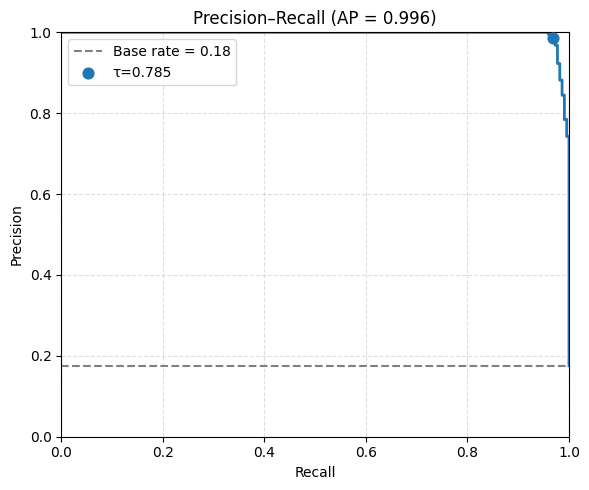

In [62]:
from sklearn.metrics import precision_recall_curve, average_precision_score

'''y_true = 1252
y_score = 1250
best_thr = 0.785'''

prec, rec, thr = precision_recall_curve(y_true, y_score)
pr_auc = average_precision_score(y_true, y_score)
base_rate = y_true.mean()

# find closest threshold index for plotting
ix = np.argmin(np.abs(thr - best_thr)) if len(thr) else None

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(rec, prec, linewidth=2)
ax.hlines(base_rate, xmin=0, xmax=1, colors="gray", linestyles="--", label=f"Base rate = {base_rate:.2f}")
if ix is not None and ix < len(prec):
    ax.scatter(rec[ix], prec[ix], s=60, zorder=5, label=f"τ={best_thr:.3f}")
ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title(f"Precision–Recall (AP = {pr_auc:.3f})")
ax.grid(True, linestyle="--", alpha=0.4)
if ix is not None: ax.legend()
plt.tight_layout()
# plt.savefig("fig_pr_curve_final.png", dpi=200)
plt.show()


## Threshold trade-off
Precision, Recall, and F1 as a function of the decision threshold. Helps justify the chosen τ.


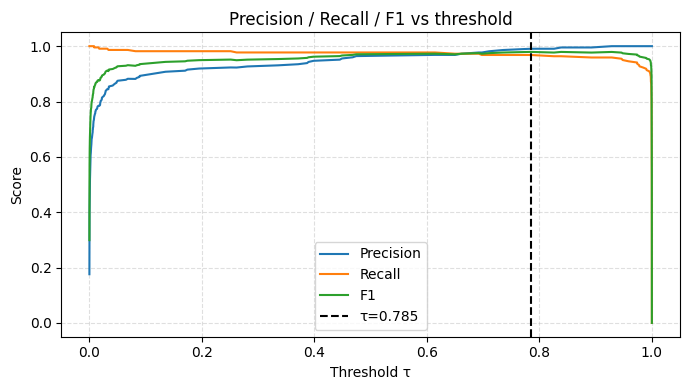

In [63]:
# Reuse prec, rec, thr from above
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(thr, prec[1:], label="Precision")  # prec/rec are 1 longer than thr
ax.plot(thr, rec[1:],  label="Recall")
ax.plot(thr, f1[1:],   label="F1")
ax.axvline(best_thr, color="k", linestyle="--", label=f"τ={best_thr:.3f}")
ax.set_xlabel("Threshold τ"); ax.set_ylabel("Score")
ax.set_title("Precision / Recall / F1 vs threshold")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.savefig("fig_threshold_tradeoff.png", dpi=200)
plt.show()


## Calibration (reliability) + Brier score
Checks whether predicted probabilities match observed leak frequency.


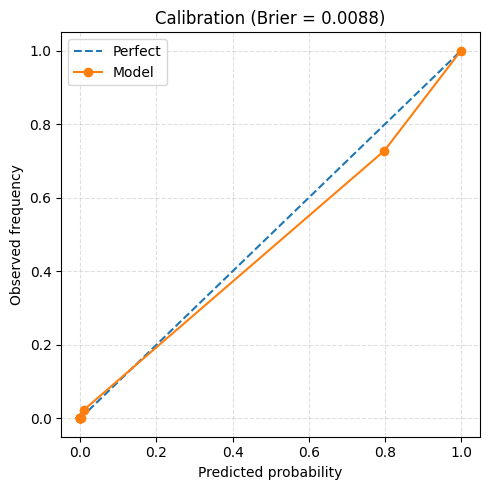

In [64]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

bs = brier_score_loss(y_true, y_score)
frac_pos, mean_pred = calibration_curve(y_true, y_score, n_bins=10, strategy="quantile")

fig, ax = plt.subplots(figsize=(5,5))
ax.plot([0,1],[0,1],"--", label="Perfect")
ax.plot(mean_pred, frac_pos, marker="o", label="Model")
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Observed frequency")
ax.set_title(f"Calibration (Brier = {bs:.4f})")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("fig_calibration.png", dpi=200)
plt.show()


## Confusion matrix @ τ
Counts and row-normalized percentages at your operating threshold.


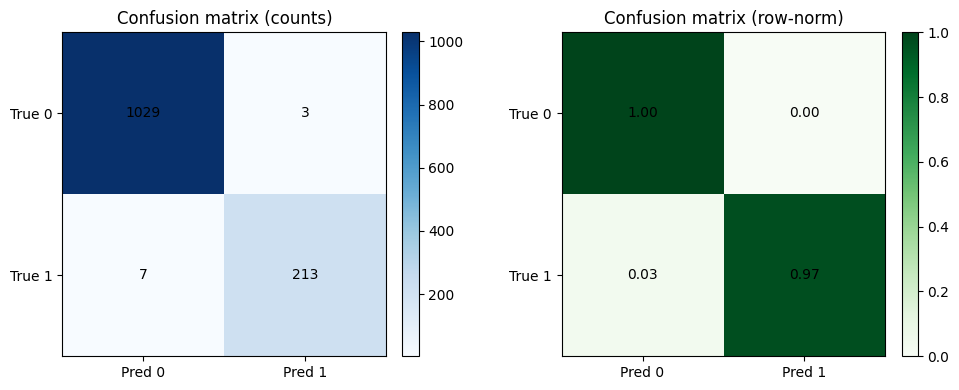

In [65]:
from sklearn.metrics import confusion_matrix

y_pred = (y_score >= best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

# raw counts
im0 = ax[0].imshow(cm, cmap="Blues")
ax[0].set_title("Confusion matrix (counts)")
ax[0].set_xticks([0,1]); ax[0].set_yticks([0,1])
ax[0].set_xticklabels(["Pred 0","Pred 1"]); ax[0].set_yticklabels(["True 0","True 1"])
for i in range(2):
    for j in range(2):
        ax[0].text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# normalized
im1 = ax[1].imshow(cm_norm, vmin=0, vmax=1, cmap="Greens")
ax[1].set_title("Confusion matrix (row-norm)")
ax[1].set_xticks([0,1]); ax[1].set_yticks([0,1])
ax[1].set_xticklabels(["Pred 0","Pred 1"]); ax[1].set_yticklabels(["True 0","True 1"])
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", color="black")
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("fig_confusion_matrix.png", dpi=200)
plt.show()


In [66]:
# Performance by material: F1 at τ with 95% bootstrap CIs
rng = np.random.default_rng(42)
materials = df.loc[y_true.index, "feat_material"] if "feat_material" in df.columns else df.loc[y_true.index, "Material"].astype(str)

def f1_at_thr(y, p, thr):
    yhat = (p >= thr).astype(int)
    tp = ((y==1)&(yhat==1)).sum(); fp = ((y==0)&(yhat==1)).sum(); fn=((y==1)&(yhat==0)).sum()
    return 2*tp / (2*tp + fp + fn + 1e-12)

rows = []
for mat in materials.fillna("Unknown").unique():
    mask = (materials.fillna("Unknown") == mat)
    if mask.sum() < 30:  # skip tiny groups
        continue
    f1 = f1_at_thr(y_true[mask], y_score[mask], best_thr)
    # bootstrap CI
    boots = []
    idx = np.where(mask)[0]
    for _ in range(500):
        samp = rng.choice(idx, size=len(idx), replace=True)
        boots.append(f1_at_thr(y_true[samp], y_score[samp], best_thr))
    lo, hi = np.percentile(boots, [2.5, 97.5])
    rows.append((mat, f1, lo, hi, mask.sum()))

seg = pd.DataFrame(rows, columns=["material","f1","lo","hi","n"]).sort_values("f1")
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(seg["material"], seg["f1"], xerr=[seg["f1"]-seg["lo"], seg["hi"]-seg["f1"]], align="center", alpha=0.8)
for y, (f1v, n) in enumerate(zip(seg["f1"], seg["n"])):
    ax.text(f1v, y, f"  n={n}", va="center")
ax.set_xlabel("F1 @ τ"); ax.set_title("Performance by Material (95% CI)")
ax.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("fig_perf_by_material.png", dpi=200)
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'index'